In [1]:
%matplotlib notebook

import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
from trajectories import simulate, simulate_rotation, get_view_vector, std_from_r, trajectory, simulate_c
from metric import rmse

In [3]:
angles = np.arange(360)
radius = 3

In [4]:
views = []
positions = []
for angle in angles:
    pos = simulate(angle, radius)
    rot = simulate_rotation(angle, radius)
    view = get_view_vector(rot, pos)
    views.append(view)
    positions.append(pos)
positions = np.array(positions)
views = np.array(views)

In [12]:
orig = []
for i in range(360):
    pos = trajectory(i, radius)
    orig.append(pos)
orig = np.array(orig)

<IPython.core.display.Javascript object>


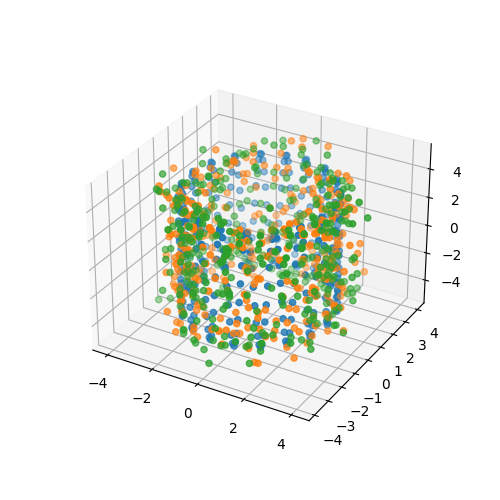

In [13]:
# filtered = np.array(filtered)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(filtered[:, 0], filtered[:, 1], filtered[:, 2])
ax.scatter(orig[:, 0], orig[:, 1], orig[:, 2])
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2])
ax.scatter(positions2[:, 0], positions2[:, 1], positions2[:, 2])

In [6]:
# views = []
positions2 = []
for angle in angles:
    pos = simulate_c(angle, radius, base_std=0.5)
#     rot = simulate_rotation(angle, radius)
#     view = get_view_vector(rot, pos)
#     views.append(view)
    positions2.append(pos)
positions2 = np.array(positions2)
# views = np.array(views)

In [9]:
final = (positions / 0.001 + positions2 / 0.5) / (1/0.001 + 1 / 0.5)

<IPython.core.display.Javascript object>


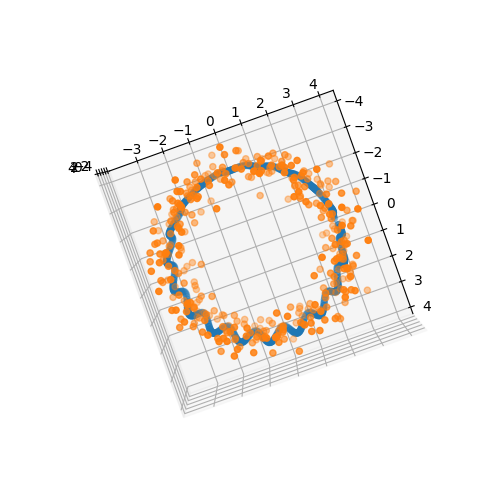

In [10]:
# filtered = np.array(filtered)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(filtered[:, 0], filtered[:, 1], filtered[:, 2])
ax.scatter(orig[:, 0], orig[:, 1], orig[:, 2])
ax.scatter(final[:, 0], final[:, 1], final[:, 2])
# ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2])
# ax.scatter(positions2[:, 0], positions2[:, 1], positions2[:, 2])

In [14]:
rmse(orig, final)

(array([0.29591911, 0.31336518, 0.31997427]), 0.3097528520926482)

In [15]:
rmse(orig, positions)

(array([0.29648203, 0.31401216, 0.32065997]), 0.31038471840415244)

In [16]:
rmse(orig, positions2)

(array([0.3985275 , 0.38451251, 0.41369172]), 0.3989105773342427)

# Kalman Filter

In [20]:
import numpy as np
from filterpy.kalman import KalmanFilter, UnscentedKalmanFilter, ExtendedKalmanFilter
# from KalmanFilter import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import pickle

In [21]:
def np_from_traj(trajectory):
    positions = []
    rotations = []
    for item in trajectory.collection:
        positions.append(item.T)
        rotations.append(item.Re)
    return np.array(positions), np.array(rotations)

In [49]:
with open('zed_trajectory.pkl', 'rb') as f:
    zed_data = pickle.load(f)

with open('gt_trajectory.pkl', 'rb') as f:
    gt_data = pickle.load(f)

with open('ms_trajectory.pkl', 'rb') as f:
    ms_data = pickle.load(f)

In [50]:
gt_traj, gt_rot = np_from_traj(gt_data)
zed_traj, zed_rot = np_from_traj(zed_data)
ms_traj, ms_rot = np_from_traj(ms_data)


In [40]:
ms_traj.shape

(3600, 3)

In [97]:
my_filter = KalmanFilter(dim_x=6, dim_z=3)

In [98]:
dt = 1
my_filter.x = [ms_traj[0][0], ms_traj[0][1], ms_traj[0][2], 0., 0., 0.]

# x, y, z, x', y', z',
my_filter.F = np.array([[1., 0, 0., dt, 0, 0],
                        [0., 1., 0, 0, dt, 0],
                        [0., 0., 1., 0., 0, dt],
                        [0., 0., 0., 1., 0., 0],
                        [0., 0., 0., 0., 1., 0],
                        [0., 0., 0, 0, 0, 1.]
                        ])    # state transition matrix

my_filter.H = np.array([
    [1., 0., 0., 0, 0, 0],
    [0., 1., 0., 0, 0, 0],
    [0., 0., 1., 0, 0, 0],
])    # Measurement function
# my_filter.P                  # covariance matrix
my_filter.R = std_from_r(0.001, radius)                      # state uncertainty
my_filter.Q = Q_discrete_white_noise(3, dt, 0.5, 2) # process uncertainty


In [99]:
filtered = []
for i in range(1, len(ms_traj)):
    my_filter.predict()
#     my_filter.update(ms_traj[i])
    my_filter.update(ms_traj[i])
    
    x = my_filter.x
    filtered.append(x)
filtered = np.array(filtered)

In [66]:
filtered.shape

(3599, 6)

<IPython.core.display.Javascript object>


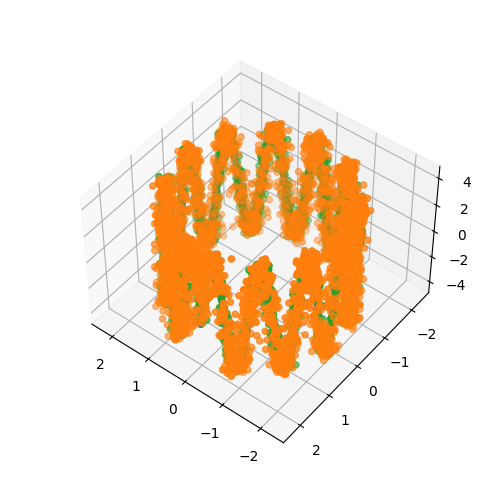

In [100]:
# filtered = np.array(filtered)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(filtered[:, 0], filtered[:, 1], filtered[:, 2])
ax.scatter(gt_traj[:, 0], gt_traj[:, 1], gt_traj[:, 2])
ax.scatter(zed_traj[:, 0], zed_traj[:, 1], zed_traj[:, 2])
ax.scatter(ms_traj[:, 0], ms_traj[:, 1], ms_traj[:, 2])

# ax.scatter(final[:, 0], final[:, 1], final[:, 2])
# ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2])
# ax.scatter(positions2[:, 0], positions2[:, 1], positions2[:, 2])

In [106]:
np.mean((gt_traj[1:] - filtered[:, :3]) ** 2)

0.0035957963545191133

In [107]:
np.mean((gt_traj[1:] - ms_traj[1:]) ** 2)

0.0030272835796374886

In [102]:
rmse(gt_traj[1:], ms_traj[1:])

(array([0.04403374, 0.04413136, 0.04375456]), 0.043973221773573795)

In [103]:
rmse(gt_traj[1:], zed_traj[1:])

(array([0.07853662, 0.08267619, 0.08028606]), 0.0804996217568613)